In [2]:
from sklearn.neural_network import MLPClassifier
from matplotlib.pyplot import *
import pandas as pd
import numpy as np
import shap

path = ".."
sys.path.append(f"{path}/src/") # Add /src/ to path
from svc import SVC
from mlp import MLPClassifier
from data_loader import DataLoader, plot_confusion_matrix

Below, we use our ```DataLoader``` to load and prune our data. Then, we use the ```SVC``` and ```MLP``` classes to initialize our models.

In [4]:
# Data path
dl = DataLoader()
X_train, X_test, y_train, y_test = dl.load(path = f"{path}/data/")
dummy_value = np.array([[1,	0,	0.92,	11000, 32,	197757,	4,	22,	8,	1000]]) # Dummy value for a quick test
feature_names = ['viewed',	'gender',	'grade',	'nevents', 'ndays_act',	'nplay_video',	'nchapters',	'age',	'votes',	'num_words']
all_classes = all_classes = ['Not Completed','Completed']

svc = SVC(from_file = True, filename= f"{path}/src/MITx-SVC.pkl") # Support Vector Classifier
mlp = MLPClassifier(from_file = True, filename = f"{path}/src/MITx-MLP.pkl") # Multi-Layer Perceptron Classifier


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Trying to unpickle estimator SVC from version 1.2.2 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator LabelBinarizer from version 1.2.2 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator MLPClassifier from version 1.2.2 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more i

For our user study, we draw from a small selection of canned data that I (Sam) sampled myself. The code below unpacks out data into two categories:
- ```_complete``` means that the students in this array completed the course
- ```_incomplete``` students didn't
- (```X_``` is the input ```y_``` is the true value for the input)

In [5]:
X_complete, y_complete, X_incomplete, y_incomplete = dl.load_sample_data(f"{path}/data/sample_data.pkl")
X_sample, y_sample = dl.load_sample_data(f"{path}/data/sample_data.pkl", concatenated = True)

Here we use a Permutation explainer. This draws a permutation of the input from the data matrix ```X_complete```. For more information on this algorithm, visit [**Shapley's Math**](https://cosmcbun.github.io/Explainable-Ai-Comps-2024/Shapley%20Values/Shapley's%20Math/) on our website. Alternatively, you can visit ```sam-shap.ipynb``` in this folder to see how I (Sam) coded a naive version of this explainer (poorly).

This first example shows how to make a bar plot of feature importances, estimated from the Shapley values across all inputs in ```X_test```. See our how **Cohort explanations** fit into our project's scope at the bottom of [**"What is XAI?"**](https://cosmcbun.github.io/Explainable-Ai-Comps-2024/Introduction/What%20is%20XAI)

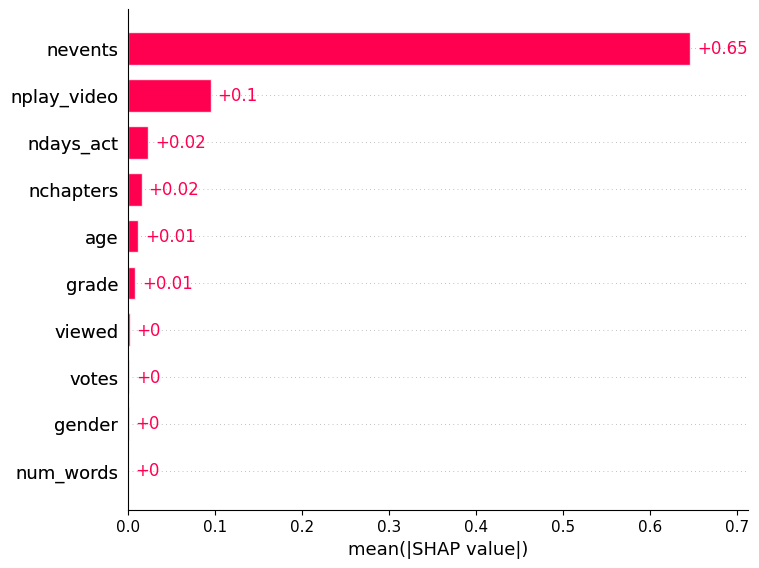

In [25]:
permutation = shap.explainers.Permutation(mlp.predict_proba, X_train, feature_names=feature_names)
perm_shap_vals = permutation(X_test)[..., 1] # Shapley values for all samples
perm_vals = permutation(X_test) # If you want, you can swap X_complete with X_test or X_incomplete
perm_shap_vals = perm_vals[..., 1] # "[..., 1]" is used to get the Shapley values for the "Completed" class. "[..., 0]" for Incomplete

''' PLOTTING: '''
import matplotlib.pyplot as plt
plt.clf()
shap.plots.bar(perm_shap_vals, show=True)
savefig(f"{path}/Shapley/Multi-Layer Perceptron/Overall.png", bbox_inches='tight')

# '''Optional plots, left unused in our project:'''
# plt.clf()
# shap.plots.violin(perm_shap_vals)
# plt.clf()
# shap.plots.heatmap(perm_shap_vals)
# plt.clf()

## User Study Visualizations (found in the "/Multi-Layer Perceptron/" folder):
Here, we create a set of visuals for our user study. Here are a couple quirks about these plots:
1. They build from the average prediction for the class of focus across the dataset you passed in when you made the ```PermutationExplainer``` (bottom, $E[f(x)]$) to the actual prediction (top-right, $f(x)$).
2. Each feature value contributes from the bottom (least significant) to the top (most significant), moving the prediction until we get our final $f(x)$.
3. Although our features here are ordered bottom-to-top in order of least significance to most significance, this does not reflect the order in which they enter the room, or the order in which the values are calculated. This is just a convenient way to display the contributions, as it makes for a pretty graph.
4. For our user study, we *always* showed them the explanation for the ```completed``` class, whether the student passed or not, and we told them that if $f(x)$ didn't hit a $>0.5$ number, then the model's output was ```incomplete```. This was to reduce visual confusion, but I (Sam) believe that our users would have gained more insight if they were shown the class that was predicted, not just ```completed```. 
5. Whether we were to show graphs ```completed``` or ```incomplete```, the Shapley values end up being almost the same, as the plots are mirrors of each other! This task is binary classification; therefore, each prediction probability are directly proportional to the inverse of the other.

In [41]:
import tqdm # Progress bar

''' If you want to save the plots, set "show" to False and set the "path" to the desired location '''
def plot_for_study(results, target, shap_vals, show = True, path = "./Multi-Layer Perceptron"):
    # Clean out any input misinterpretation:
    if path[-1] == "/":
        path = path[:-1]
    # Naming scheme for the plots:
    true_result = "Positive" if target==1 else "Negative"
    tr = "P" if target==1 else "N"
    false_result = "Positive" if target==0 else "Negative"
    fr = "P" if target==0 else "N"
    # Plotting:
    plt.clf()
    for i in tqdm.tqdm(range(0, len(results))):
        if results[i] == target: # Hits
            shap.plots.waterfall(shap_vals[i], show=show)
            if not show:
                plt.savefig(f"{path}/True {true_result}/T{tr}_{i}.png", bbox_inches='tight')
            plt.clf()
        elif results[i] != target: # Misses
            shap.plots.waterfall(shap_vals[i], show=show)
            if not show:
                plt.savefig(f"{path}/False {false_result}/F{fr}_{i}.png", bbox_inches='tight')
            plt.clf()

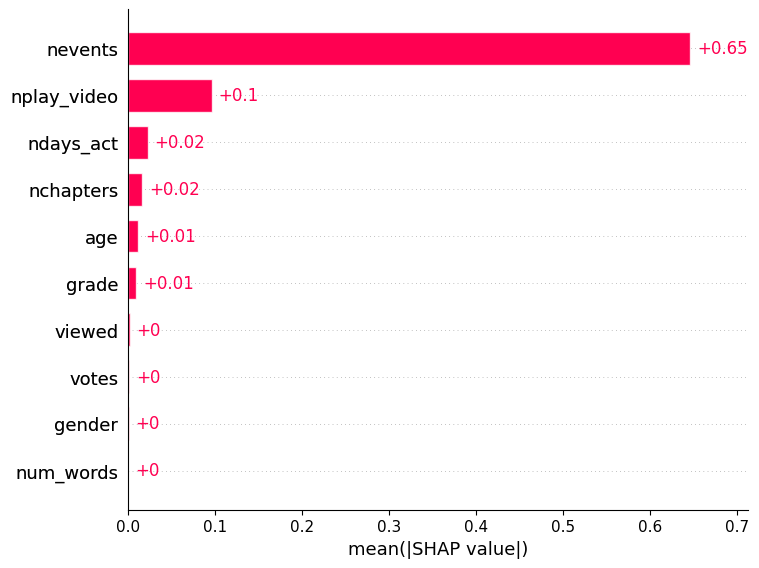

100%|██████████| 50/50 [00:23<00:00,  2.13it/s]


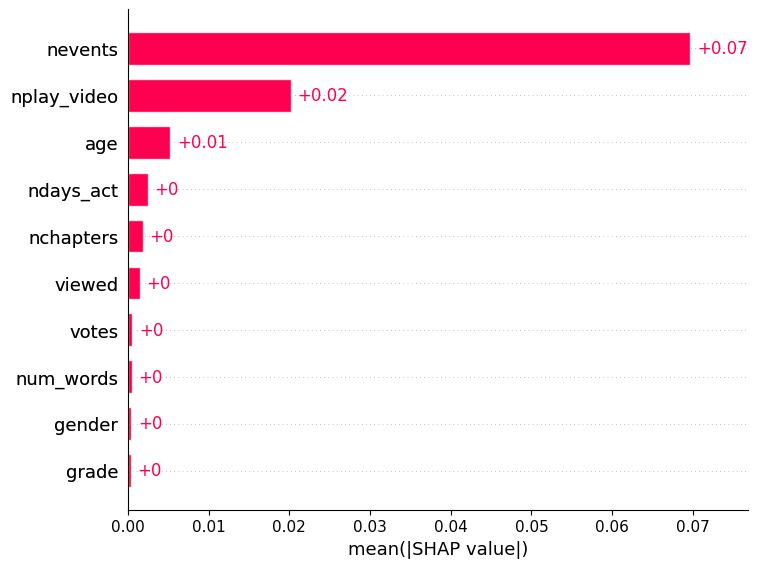

100%|██████████| 50/50 [00:22<00:00,  2.26it/s]


In [42]:
''' Plotting for the Completed class '''
perm_vals = permutation(X_complete)
results = mlp.predict(X_complete)
pos = perm_vals[..., 1]
shap.plots.bar(pos, max_display=1000)
plt.clf()
plot_for_study(results, 1, pos, show=False)

''' Plotting for the Incomplete class '''
perm_vals = permutation(X_incomplete)
results = mlp.predict(X_incomplete)
pos = perm_vals[..., 1]
shap.plots.bar(pos, max_display=1000)
plt.clf()
plot_for_study(results, 0, pos, show=False)